In [2]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import pickle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt


/Users/Wendo99/miniconda3/envs/NYC_Taxi/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Load and unzip taxidata

In [3]:
def load_taxi_data():
    download_file_name = "nyc-taxi-trip-duration.zip"
    data_dir = Path("data_packages")
    extracted_dir = Path("data")
    csv_path = extracted_dir / "train.csv"
    pkl_path = extracted_dir / "train.pkl"

    zip_path = data_dir / download_file_name

    # Schritt 0: Schneller CSV-Zugriff über Cache (falls vorhanden)
    if pkl_path.is_file():
        with open(pkl_path, "rb") as f:
            return pickle.load(f)

    # Schritt 1: Download nur wenn ZIP noch fehlt
    if not zip_path.is_file():
        data_dir.mkdir(parents=True, exist_ok=True)
        api = KaggleApi()
        api.authenticate()
        api.competition_download_files("nyc-taxi-trip-duration", path=data_dir)

    # Schritt 2: Entpacke ZIP nur, wenn innere ZIPs fehlen
    inner_zip_names = {"train.zip", "test.zip", "sample_submission.zip"}
    existing_inner_zips = {z.name for z in data_dir.glob("*.zip")}
    missing_inner_zips = inner_zip_names - existing_inner_zips

    if missing_inner_zips:
        with ZipFile(zip_path, 'r') as outer_zip:
            outer_zip.extractall(data_dir)

    # Schritt 3: Entpacke nur fehlende CSVs aus inneren ZIPs
    extracted_dir.mkdir(parents=True, exist_ok=True)
    for inner_zip in data_dir.glob("*.zip"):
        with ZipFile(inner_zip, 'r') as zip_ref:
            for member in zip_ref.namelist():
                if member.endswith(".csv"):
                    target_file = extracted_dir / Path(member).name
                    if not target_file.is_file():
                        zip_ref.extract(member, path=extracted_dir)

    # Schritt 4: CSV laden und pkl-Cache speichern
    if not csv_path.is_file():
        raise FileNotFoundError(f"'{csv_path}' wurde nicht gefunden – Entpackung fehlgeschlagen.")

    df = pd.read_csv(csv_path)
    with open(pkl_path, "wb") as f:
        pickle.dump(df, f)

    return df

# Anwendung
taxi = load_taxi_data()

# Explore taxi data

### Structure

Objective of the Exploration
- Understand the structure and completeness of the taxi trip dataset (train.csv): number of rows,
variable types, missing values, and uniqueness of entries.

In [9]:
# taxi.shape
# taxi.columns
# taxi.dtypes
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [11]:
taxi.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [12]:
taxi.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

Findings of the Exploration
- Dataset contains 1,458,644 rows and 11 columns.
- All core variables are present: timestamps, geolocations, duration, passenger count, etc.
- Data types are mixed: object for timestamps and flags, int or float for coordinates and durations.
- No missing values in the core fields.
- Most variables show high cardinality, suggesting rich variation.

Required Arrangements
- Convert pickup_datetime and dropoff_datetime to datetime objects.
- Check whether any values (e.g. coordinates or duration) are invalid or extreme in the next steps.


In [13]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])

### Check for invalid or extreme values

Objective of the Exploration

Evaluate the value ranges of trip duration and coordinates to detect invalid entries or outliers that may distort analysis or modeling.

In [14]:
# Summary statistics for trip duration
taxi['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [15]:
# Summary statistics for coordinates
taxi[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,4.075092e+01,-7.397349e+01,4.075180e+01,-7.397342e+01
std,3.288119e-02,7.090186e-02,3.589056e-02,7.064327e-02
min,3.435970e+01,-1.219333e+02,3.218114e+01,-1.219333e+02
25%,4.073735e+01,-7.399187e+01,4.073588e+01,-7.399133e+01
50%,4.075410e+01,-7.398174e+01,4.075452e+01,-7.397975e+01
75%,4.076836e+01,-7.396733e+01,4.076981e+01,-7.396301e+01
max,5.188108e+01,-6.133553e+01,4.392103e+01,-6.133553e+01


In [43]:
# Check for extreme trip durations
taxi[taxi['trip_duration'] > 3 * 3600]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
...,...,...,...,...,...,...,...,...,...,...,...
1455097,id2798196,2,2016-03-20 03:51:36,2016-03-21 00:00:00,2,-73.969299,40.757301,-73.870277,40.709808,N,72504
1456458,id2055880,2,2016-02-08 19:11:31,2016-02-09 19:08:44,3,-73.973282,40.760792,-73.988518,40.764210,N,86233
1457207,id1910950,2,2016-06-08 16:29:12,2016-06-09 16:11:03,1,-73.958061,40.800869,-73.964119,40.805515,N,85311
1457752,id1215198,2,2016-02-02 11:31:10,2016-02-03 11:29:44,6,-73.972069,40.794220,-73.961014,40.806728,N,86314


In [45]:
taxi[taxi['trip_duration'] < 60]  # < 1 minute

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,57
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,40
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,3
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,58
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,2
...,...,...,...,...,...,...,...,...,...,...,...
1458044,id3200588,2,2016-03-12 01:35:35,2016-03-12 01:35:42,1,-74.007378,40.739441,-74.007378,40.739449,N,7
1458085,id1326136,2,2016-05-21 12:07:11,2016-05-21 12:07:28,1,-73.978935,40.762463,-73.977654,40.762012,N,17
1458140,id0175875,1,2016-03-22 06:18:10,2016-03-22 06:18:47,1,-73.991325,40.744934,-73.989388,40.748024,N,37
1458544,id3958653,1,2016-06-16 15:10:11,2016-06-16 15:10:49,1,-73.956459,40.767231,-73.956589,40.767269,N,38


In [44]:
# Check for invalid coordinates
taxi[
    (taxi['pickup_latitude'].abs() > 90) |
    (taxi['pickup_longitude'].abs() > 180) |
    (taxi['dropoff_latitude'].abs() > 90) |
    (taxi['dropoff_longitude'].abs() > 180)
]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [47]:
taxi[
    (taxi['pickup_latitude'] < 40.5) | (taxi['pickup_latitude'] > 41.0) |
    (taxi['dropoff_latitude'] < 40.5) | (taxi['dropoff_latitude'] > 41.0) |
    (taxi['pickup_longitude'] < -74.3) | (taxi['pickup_longitude'] > -73.6) |
    (taxi['dropoff_longitude'] < -74.3) | (taxi['dropoff_longitude'] > -73.6)
]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
115,id2358953,2,2016-06-27 00:31:28,2016-06-27 01:06:44,1,-73.870819,40.773739,-73.857498,41.017811,N,2116
991,id1859156,1,2016-02-17 00:54:13,2016-02-17 01:36:27,3,-73.969254,40.754047,-73.593582,41.043865,N,2534
1101,id3913560,2,2016-01-11 22:48:55,2016-01-11 23:40:20,2,-74.012657,40.702179,-74.307762,40.567341,N,3085
9565,id0304778,1,2016-02-23 20:38:44,2016-02-23 21:19:17,1,-73.982925,40.761841,-74.379631,40.745274,N,2433
13006,id3022813,1,2016-06-15 18:02:41,2016-06-15 18:03:18,1,-73.558289,40.781223,-73.558281,40.781227,N,37
...,...,...,...,...,...,...,...,...,...,...,...
1449228,id2148312,2,2016-04-23 22:44:36,2016-04-23 23:31:57,1,-73.790451,40.646904,-73.837021,41.061226,N,2841
1449384,id3101192,1,2016-05-17 20:43:33,2016-05-17 22:13:12,2,-73.979401,40.752388,-73.872871,41.040192,N,5379
1450700,id1292498,1,2016-06-23 07:02:07,2016-06-23 08:28:12,1,-73.782013,40.644894,-73.774452,41.031044,N,5165
1454301,id1367595,2,2016-04-09 01:38:09,2016-04-09 02:14:52,1,-74.047142,40.789986,-74.010872,41.112366,N,2203


In [49]:
taxi[
    (taxi['pickup_latitude'].round(5) == taxi['dropoff_latitude'].round(5)) &
    (taxi['pickup_longitude'].round(5) == taxi['dropoff_longitude'].round(5)) &
    (taxi['trip_duration'] > 300)  # more than 5 minutes
]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580
2609,id1992673,2,2016-03-02 20:10:41,2016-03-02 20:30:53,5,-73.875313,40.773682,-73.875313,40.773682,N,1212
3014,id3206922,2,2016-04-24 18:38:34,2016-04-24 18:48:32,1,-73.985168,40.736259,-73.985168,40.736259,N,598
...,...,...,...,...,...,...,...,...,...,...,...
1455304,id1799905,2,2016-02-17 08:08:40,2016-02-17 08:16:49,1,-73.981995,40.759571,-73.981995,40.759571,N,489
1456135,id1441158,1,2016-03-17 21:53:37,2016-03-17 22:01:16,2,-73.978439,40.736889,-73.978439,40.736889,N,459
1456399,id0618137,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,N,1284
1456989,id2595295,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,N,566


In [50]:
taxi[taxi['passenger_count'] > 6]  # NYC Yellow Cab  max. 6 seats

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
433304,id3280610,2,2016-06-07 10:06:24,2016-06-07 10:06:43,7,-74.173668,40.737274,-74.173660,40.737297,N,19
436047,id2489742,2,2016-06-24 08:09:21,2016-06-24 08:18:41,9,-73.710632,40.671581,-73.710632,40.671581,N,560
489613,id0506488,2,2016-05-08 22:39:08,2016-05-08 22:39:23,7,-74.039482,40.715031,-74.039482,40.715019,N,15
824904,id0988237,2,2016-04-23 19:46:08,2016-04-23 19:46:33,7,-73.631149,40.768551,-73.631149,40.768551,N,25
826064,id1488553,2,2016-01-01 01:15:20,2016-01-01 01:17:04,8,-73.992653,40.768719,-74.041374,40.729954,N,104


Findings of the Exploration
- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.
- Coordinate values are numerically valid but not always geographically plausible. Some trips lie outside typical NYC boundaries (latitude 40.5–41.0, longitude −74.3 to −73.6).
- A subset of trips has identical pickup and dropoff locations but long durations, which is potentially a GPS or logging error.
- A small number of trips report more than 6 passengers, which exceeds the legal or practical capacity of standard NYC cabs.



Required Arrangements
- Filter out trips with duration < 1 minute or > 2 hours to remove unrealistic records.
- Remove all trips with coordinates outside NYC boundaries to avoid GPS or data errors.
- Flag or remove trips where pickup and dropoff locations are (nearly) identical and duration > 5 minutes.
- Remove or flag all trips with passenger_count > 6 as physically implausible.

### Geographic distribution

Objective of the Exploration
- Understand the geographic distribution of pickup and dropoff locations. Detect possible GPS
errors, clusters, or unrealistic values.

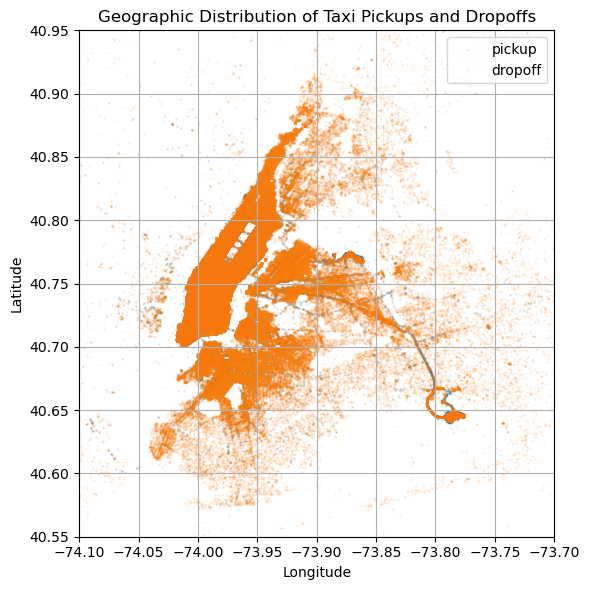

In [53]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi['pickup_longitude'], taxi['pickup_latitude'], s=0.5, alpha=0.1, label='pickup')
plt.scatter(taxi['dropoff_longitude'], taxi['dropoff_latitude'], s=0.5, alpha=0.1, label='dropoff')
plt.xlim(-74.1, -73.7)
plt.ylim(40.55, 40.95)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

Findings of the Exploration
- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.
- Clear density clusters appear around Midtown and Downtown Manhattan.

Required Arrangements
- Later: Remove or filter coordinates outside the approximate bounds of NYC:
    - Latitude: 40.5 – 41.0
    - Longitude: −74.3 – −73.6
- Optionally define bounding boxes for boroughs or airports for further geographic feature engineering.

### Categorical variables

Objective of the Exploration
- Understand the distribution and validity of categorical variables like vendor_id,
store_and_fwd_flag, and passenger_count. Detect irregularities or uncommon values.

In [54]:
# Vendor ID
taxi['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [55]:
# Store and forward flag
taxi['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

In [56]:
# Passenger count
taxi['passenger_count'].value_counts().sort_index()

passenger_count
0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: count, dtype: int64

Findings of the Exploration
- vendor_id contains only two values (1 and 2), as expected. These likely represent two taxi companies.
- store_and_fwd_flag contains mostly N, with a small number of Y. This flag indicates whether the record was stored before forwarding (e.g., due to no signal).
- passenger_count ranges from 0 to 9. Values like 0 and >6 are implausible and may indicate data errors or rare cases (e.g., package delivery, data entry mistakes).

Required Arrangements
- Consider removing or flagging records with passenger_count < 1 or > 6.
- One-hot-encode vendor_id and store_and_fwd_flag if used in models.
- Optionally bin passenger_count into simplified categories: solo, small group (2–4), full load (5–6), unknown (0, >6).

### Target variable trip_duration

Objective of the Exploration
- Understand the distribution and scale of the target variable trip_duration. Identify skewness,
outliers, and determine whether transformation is necessary for modeling.

In [57]:
# Trip duration in minutes
taxi['trip_duration_min'] = taxi['trip_duration'] / 60

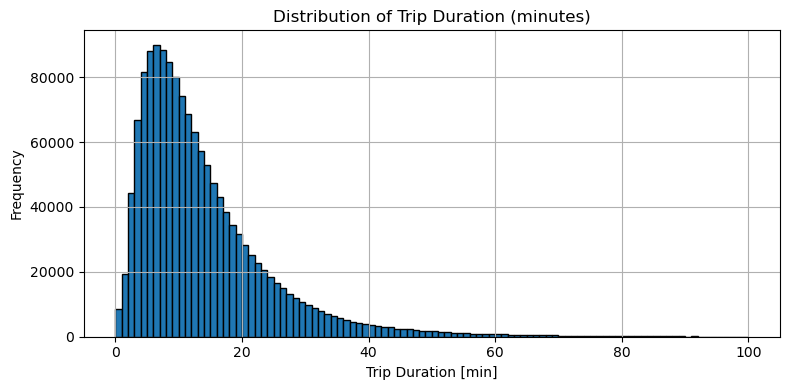

In [58]:
# Histogram (capped at 100 minutes for clarity)
plt.figure(figsize=(8, 4))
plt.hist(taxi['trip_duration_min'], bins=100, range=(0, 100), edgecolor='black')
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Trip Duration [min]")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

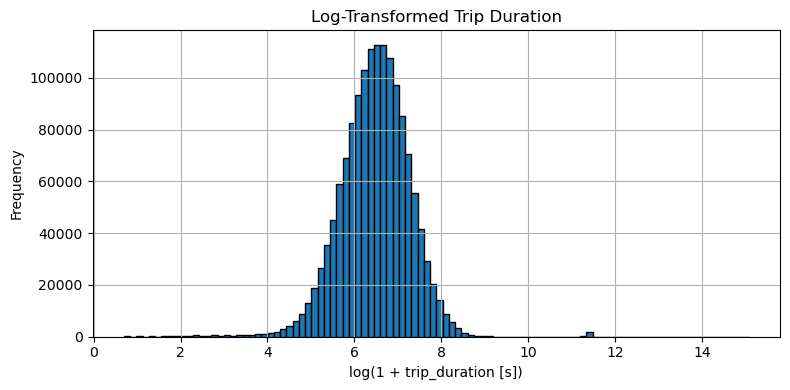

In [59]:
import numpy as np

# Log-transformed trip duration
taxi['trip_duration_log'] = np.log1p(taxi['trip_duration'])

plt.figure(figsize=(8, 4))
plt.hist(taxi['trip_duration_log'], bins=100, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Log-Transformed Distribution
1. Reduces skewness
The original trip durations are highly skewed: most rides are short, but a few last hours. This heavy right tail can distort models.
The log transformation compresses large values and spreads out small ones, leading to a more balanced distribution.

2. Improves model behavior
Many regression algorithms (like linear regression) assume that the target variable is normally distributed or homoscedastic (constant variance).
The log-transformed duration better fulfills these assumptions.

3. Makes error more meaningful
Model errors in log space correspond to multiplicative errors in the original space. This means:
- predicting 10 minutes instead of 5 (factor 2) is treated the same as 60 instead of 30.

When to avoid it?
- If your model or interpretation needs durations in raw units.
- If your duration already has a narrow, well-behaved range (not the case here).

***

Findings of the Exploration
- The original distribution is strongly right-skewed: most trips last less than 30 minutes, but some exceed 2 hours.
- A log-transformation significantly stabilizes the distribution, making it more suitable for linear models or models assuming normality.
- A few extreme values (very long trips) may distort the mean or variance if unfiltered.


Required Arrangements
- Use the log-transformed trip_duration_log as target variable for regression models.
- Keep trip_duration_min for interpretability and visual analysis.
- Consider capping or removing values >2 hours depending on modeling strategy.


### Extracting time-based features

Objective of the Exploration
- Extract interpretable and useful temporal features from the pickup_datetime to support
seasonality analysis, rush-hour detection, and feature generation for modeling.

In [60]:
# Basic datetime features
taxi['pickup_hour'] = taxi['pickup_datetime'].dt.hour
taxi['pickup_dayofweek'] = taxi['pickup_datetime'].dt.dayofweek  # 0 = Monday
taxi['pickup_month'] = taxi['pickup_datetime'].dt.month

# Day of year and hour of year (for merging with weather)
taxi['pickup_dayofyear'] = taxi['pickup_datetime'].dt.dayofyear
taxi['pickup_hourofyear'] = (taxi['pickup_dayofyear'] - 1) * 24 + taxi['pickup_hour']

Findings of the Exploration
- These features capture weekly and daily cycles in traffic (e.g. rush hour, weekday vs. weekend).
- pickup_hourofyear is especially useful for merging with hourly weather data.
- No anomalies found in datetime values; extraction is stable and complete.

Required Arrangements
- Keep these features for modeling as numeric or categorical inputs.
- Optional: encode pickup_dayofweek or pickup_hour cyclically (e.g. using sin/cos) for tree-free models.
- Use pickup_hourofyear for weather-data joins.

In [61]:
taxi

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_duration_min,trip_duration_log,pickup_hour,pickup_dayofweek,pickup_month,pickup_dayofyear,pickup_hourofyear
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,6.122493,17,0,3,74,1769
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,6.498282,0,6,6,164,3912
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,7.661527,11,1,1,19,443
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,6.063785,19,2,4,97,2323
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,6.077642,13,5,3,86,2053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,12.966667,6.658011,13,4,4,99,2365
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,10.916667,6.486161,7,6,1,10,223
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,12.733333,6.639876,6,4,4,113,2694
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,6.216667,5.924256,15,1,1,5,111
